In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.utils import np_utils
from keras import initializers
from keras import backend as K
from keras.callbacks import TensorBoard
import keras

Using TensorFlow backend.


## training params

In [2]:

batch_size = 256
epochs = 10

pool_size = (2, 2)                    # size of poolin area for max pooling
prob_drop_conv = 0.2                  # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5                # drop probability for dropout @ fc layer

## data params

In [3]:
# data params
nb_classes = 10


## Load MNIST dataset

In [4]:
(X_train_raw, Y_train_raw), (X_test_raw, Y_test_raw) = mnist.load_data()
print('X_train_raw original shape:', X_train_raw.shape)

X_train_raw original shape: (60000, 28, 28)


### Reshape Data from image matrix to array & normalize


In [5]:
if K.image_dim_ordering() == 'th':

    # Theano
    X_train = X_train_raw.reshape(X_train_raw.shape[0], 1, X_train_raw.shape[1], X_train_raw.shape[2]).astype('float32')
    X_train /= 255.

    X_test = X_test_raw.reshape(X_test_raw.shape[0], 1, X_test_raw.shape[1], X_test_raw.shape[2]).astype('float32')
    X_test /= 255.
    
    input_shape = (1, X_train_raw.shape[1], X_train_raw.shape[2])
    
else:
    
    # TensorFlow
    X_train = X_train_raw.reshape(X_train_raw.shape[0], X_train_raw.shape[1], X_train_raw.shape[2], 1).astype('float32')
    X_train /= 255.

    X_test = X_test_raw.reshape(X_test_raw.shape[0], X_test_raw.shape[1], X_test_raw.shape[2], 1).astype('float32')
    X_test /= 255.
    
    input_shape = (X_train_raw.shape[1], X_train_raw.shape[2], 1)
    
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('input_shape: ', input_shape)

X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)
input_shape:  (28, 28, 1)


In [6]:
Y_train = np_utils.to_categorical(Y_train_raw)

Y_test = np_utils.to_categorical(Y_test_raw)

## Convolutional Network model

In [7]:
model = Sequential()

# conv1 layer
model.add(Conv2D(32, (3,3), padding='same', kernel_initializer='random_normal', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Dropout(prob_drop_conv))

# conv2 layer
model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='random_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Dropout(prob_drop_conv))

# conv3 layer
model.add(Conv2D(128, (3,3), padding='same', kernel_initializer='random_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

# fc1 layer
# why is it 625 here??
model.add(Dense(units=625, kernel_initializer='random_normal'))
model.add(Activation('relu'))
model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(units=10, kernel_initializer='random_normal'))
model.add(Activation('softmax'))
          
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## Train

In [8]:
import time
timestamp = time.strftime("%Y%m%d-%H%m%S")
log_dir = '/home/mhuang/tensorboard_logs/tutorial/minist/' + timestamp
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, batch_size=2*batch_size, write_images=True)

In [9]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.30, verbose=1, callbacks=[tensorboard_callback])

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 7s 169us/step - loss: 0.4541 - acc: 0.8514 - val_loss: 0.0907 - val_acc: 0.9712
Epoch 2/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.1155 - acc: 0.9637 - val_loss: 0.0689 - val_acc: 0.9785
Epoch 3/10
42000/42000 [==============================] - 6s 140us/step - loss: 0.0769 - acc: 0.9758 - val_loss: 0.0542 - val_acc: 0.9828
Epoch 4/10
42000/42000 [==============================] - 6s 140us/step - loss: 0.0600 - acc: 0.9815 - val_loss: 0.0388 - val_acc: 0.9886
Epoch 5/10
42000/42000 [==============================] - 6s 138us/step - loss: 0.0489 - acc: 0.9849 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 6/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.0406 - acc: 0.9870 - val_loss: 0.0348 - val_acc: 0.9897
Epoch 7/10
42000/42000 [==============================] - 6s 139us/step - loss: 0.0369 - acc: 0.9885 - val_loss: 0.0328 - 

In [10]:
history.history

{'acc': [0.85140476190476189,
  0.96373809523809528,
  0.97583333333333333,
  0.981547619047619,
  0.98488095238095241,
  0.98695238095238091,
  0.98847619047619051,
  0.98919047619047618,
  0.99069047619047623,
  0.99128571428571433],
 'loss': [0.45414619656687694,
  0.11548310000555856,
  0.07691969227365085,
  0.060027584071670262,
  0.048937801058803285,
  0.040618425108847167,
  0.036943297670001075,
  0.034014488876398123,
  0.02864929088099771,
  0.027085729928243728],
 'val_acc': [0.97122222222222221,
  0.97850000000000004,
  0.98277777777777775,
  0.98861111111111111,
  0.99027777777777781,
  0.98966666666666669,
  0.99022222222222223,
  0.99105555555555558,
  0.99199999999999999,
  0.98738888888888887],
 'val_loss': [0.090687802821397781,
  0.068904922087987264,
  0.05424178871760766,
  0.038753115934009354,
  0.032587534304087361,
  0.034776085657378039,
  0.032821224968466491,
  0.029080162898171693,
  0.02859471015797721,
  0.040111407963765992]}

## Evaluate

In [11]:
evaluation = model.evaluate(X_test, Y_test, batch_size=2*batch_size, verbose=1)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 0s 41us/step
Summary: Loss over the test dataset: 0.0307, Accuracy: 0.9905


## Predict

In [12]:
test_predictions = model.predict(X_test)
test_prediction_ids = test_predictions.argmax(axis=1)

## Plot some predictions

In [13]:
from matplotlib import pyplot as plt
import numpy as np
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [14]:
n_view = 4

idx = np.random.permutation(range(0,len(X_test)))[:n_view]

imgs = X_test[idx,:].reshape(n_view, X_train_raw.shape[1], X_train_raw.shape[2])
titles = test_prediction_ids[idx]

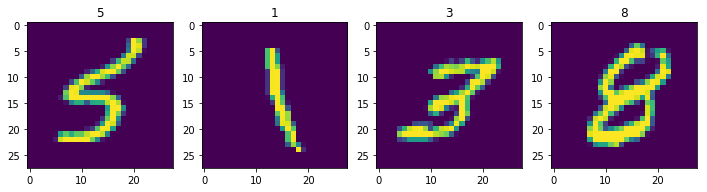

In [15]:
plots(imgs, titles=titles)
plt.show()

## Examine wrong predictions


In [16]:
# convert category vector into category label
Y_test_ids = Y_test.argmax(axis=1)

# compare the predicted and actual category labels to find error predictions
errors = np.array(Y_test_ids) - np.array(test_prediction_ids)

# gather all the wrong prediction indices
errors_idx = np.nonzero(errors)[0]

In [17]:
n_view = 4

random_idx = np.random.permutation(range(0,len(errors_idx)))[:n_view]

# grab a sampling of error indices 
random_errors_idx = errors_idx[random_idx]

# and prepare their images and labels
imgs = X_test[random_errors_idx,:].reshape(n_view, X_train_raw.shape[1], X_train_raw.shape[2])
titles = test_prediction_ids[random_errors_idx]

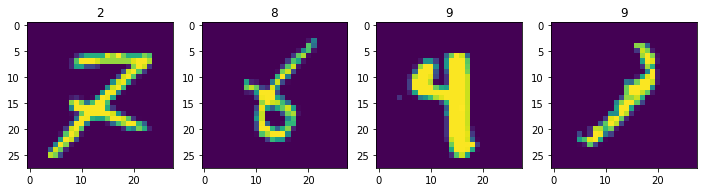

In [18]:
plots(imgs, titles=titles)
plt.show()

In [19]:
len(errors_idx) / 10000.


0.0095